In [1]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d
from error_bounds import *
from sympy import symbols, diff, factorial, Function, prod
import numpy as np

## Higher order finite differences
We want to bound the error for the derivative 1,2, and 3
For this we need to calculate the derivative of the residue and the lagrange polynomial

#### Residue $r_n(x)=\frac{u^{(n+1)}(\xi (x))}{(n+1)!}\prod_{k=0}^n(x-x_k)$

#### Lagrange coefficient $L_{n,k}(x) =\prod_{i=0,i\neq k}^n \frac{x-x_i}{x_k-x_i}$

In [13]:
#Calculates the Lagrangian
def Ln_k(x, n, k):
    Ln_k_expr = prod((x - symbols(f'x_{i}')) / (symbols(f'x_{k}') - symbols(f'x_{i}')) for i in range(0,n+1) if i != k)
    return Ln_k_expr
#Calculates the residue function
def residue(x,n):
    xi = Function('xi')(x)
    u = Function('u')(x)
    expr = u.diff(x, n + 1).subs(x, xi) / factorial(n + 1) * prod(x - symbols('x_{}'.format(i)) for i in range(0,n+1))
    return expr    

In [14]:
"""
n: finite differences order
l: order of the derivative
m: we evaluate the expression at x_m
"""
def residue_derivative(m,n,l):
    x_sympol = symbols('x')
    symbol_values={}
    symbol_values['x'] = 'x_{}'.format(m)
    #Calculate derivative
    residue_expr = residue(x_sympol,n)
    derivative = diff(residue_expr,x_sympol,l)

    residue_expr_xm = residue_expr.subs(symbol_values)
    derivative_xm = derivative.subs(symbol_values)
    return derivative_xm

"""
n: finite differences order
l: order of the derivative
m: we evaluate the expression at x_m
k: number of lagrange coefficient
"""
def lagrange_derivative(m,n,k,l):
    x_sympol = symbols('x')
    symbol_values={}
    symbol_values['x'] = 'x_{}'.format(m)
    
    lagrange_expr = Ln_k(x_sympol,n, k)
    #print(lagrange_expr)
    derivative = diff(lagrange_expr,x_sympol,l)
    
    lagrange_expr_xm = lagrange_expr.subs(symbol_values)
    derivative_xm = derivative.subs(symbol_values)
    return derivative_xm

In [15]:
n,l,m,k = 3,1,1,1
res_der=residue_derivative(m,n,l)
lagrange_der=lagrange_derivative(m,n,k,l)
print(res_der)

(-x_0 + x_1)*(x_1 - x_2)*(x_1 - x_3)*Derivative(u(xi(x_1)), (xi(x_1), 4))/24


### Upper bound derivative
If we assume $\tilde{u}(x)=u(x)+e(x)$ with $e(x)<\epsilon$ then for $p_n(u,x) = \sum_{k=0}^nu(x_k)L_k(x) $: 
$$ | u^{(l)}(x) - p_n^{(l)}(\tilde{u},x) | \leq |r_n^{(l)}(x)| + \epsilon\sum_{k=0}^n|L_k^{(l)}(x)| $$
We call $|r_n^{(l)}(x)|$ the approximation error and $\epsilon\sum_{k=0}^n|L_k^{(l)}(x)|$ the measurement error.

In [37]:
"""
Replaces all derivatives specified with begin_deriv and end_deriv with constants
m is the number of the data point used for the lagrange polynomial
"""    
def replace_u_xi_derivative(m,expression, begin_deriv, end_deriv):
    h=symbols('h')
    x = symbols('x')
    xi = Function('xi')(x)
    u = Function('u')(x)
    replaced_expression=expression
    #Replace all derivatives in u by constant C_u{i}
    for u_lth in range(end_deriv,begin_deriv,-1):
            
            u_derivative = u.diff(x, u_lth).subs(x, xi)
            u_derivative = u_derivative.subs(x,symbols(f"x_{m}")).subs(symbols(f"x_{m}"),h*m)
            #print(f"{u_lth} derivatve: {u_derivative} ")
           # print(f"Before: {replaced_expression} ")
            replaced_expression = replaced_expression.subs(u_derivative, symbols(f"C_u{u_lth}"))
            #print(f"After: {replaced_expression} ")
    #Replace all derivatives in xi by constant C_xi{i}
    #print("---")
    for xi_lth in range(begin_deriv,0,-1):
            xi_derivative = xi.diff(x, xi_lth)
            xi_derivative = xi_derivative.subs(x,symbols(f"x_{m}")).subs(symbols(f"x_{m}"),h*m)
            #print(f"{xi_lth} derivatve: {xi_derivative} ")
            #print(f"Before: {replaced_expression} ")
            replaced_expression = replaced_expression.subs( xi_derivative, symbols(f"C_xi{xi_lth}")  )
            #print(f"After: {replaced_expression} ")
    return replaced_expression

In [38]:
# we only use central differences so m=order_fd/2
def get_measurement_approximation_constants(order_fd, order_derivative,m):
     #Get measurement error
    h=symbols('h')
    x=np.arange(0,order_fd+1)
    symbol_values={}
    symbol_values = {f'x_{i}': x[i]*h for i in range(order_fd+1)}
    C_meas=0.0
    for k in range(order_fd+1):
            lagrange_der=lagrange_derivative(m,order_fd,k,order_derivative)
            value = lagrange_der.subs(symbol_values)
            C_meas += abs(value)

    #Calculate approximation error
    symbol_values = {f'x_{i}': h*x[i] for i in range(order_fd+1)}
    res_expr=residue_derivative(m,order_fd,order_derivative)
    res_der =res_expr.subs(symbol_values)
    res_expr_replaced = replace_u_xi_derivative(m,res_der, order_fd,order_fd+order_derivative+1)
    # Take the absolute value of each term individually
    C_app = sum(abs(term) for term in res_expr_replaced.as_ordered_terms())
    return C_meas,C_app

In [56]:
"""
Cu: We assume that all derivatives of u up order_fd+order_derivative can be bounded by Cu
Cxi: We assume that all derivatives of xi up to order_fd can be bounded by Cxi
h: h is the space between data points
eps: eps is the upper bound on the noise on u |u-u_noise|_infty < eps
order_fd: is the finite difference_order
order_derivative: is the order of the derivative
"""
def upper_bound_central_differences(eps,order_fd,order_derivative,Cu,Cxi,h):
    assert(order_fd%2==0)
    m=int(order_fd/2)
    C_meas,C_app = get_measurement_approximation_constants(order_fd,order_derivative,m)
    symbol_values = {f'C_u{i}': Cu for i in range(order_fd+1,order_fd+order_derivative+1)}
    symbol_values.update({f'C_xi{i}': Cxi for i in range(1,order_derivative)})
    C_app=C_app.subs(symbol_values)
    #print("Old",C_app,C_meas)
    C_app=C_app.subs(symbols('h'),h)
    C_meas=C_meas.subs(symbols('h'),h)
    #print("Old",C_app,eps*C_meas)
    upper_bound = C_app+eps*C_meas
    return upper_bound

In [40]:
order_fd,order_derivative=4,1
eps=1
Cu,Cxi=1,1
upper_bound_central_differences(eps,order_fd,order_derivative,Cu,Cxi,h=0.01)

Old Abs(h**4)/30 3/(2*Abs(h))


150.000000000333

### Test upper bound finite differences

In [26]:
from numpy.linalg import matrix_rank, svd
import pandas as pd
#Create data
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)


a=np.random.randn()
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
"""
dx=x[1]-x[0]
Cu= infinity_norm(u)
Cxi =1.0
data = {'Order_derivative': [], 'Order': [], 'Noise level': [], 'eps': [], '|ux-ux_noise|': [], 'bound': []}#,'old_bound': []}

In [27]:
ux_fd = ps.FiniteDifference(order=3,d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux_fd.flatten()
g= np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print(g.shape)
print(f"Matrix rank = {matrix_rank(g)}, svd = {svd(g, compute_uv=False)}")

(40000, 2)
Matrix rank = 2, svd = [5.35918573e+03 2.13582326e-03]


In [28]:
number_noise = 8  # <= 10
noise_levels = [0] + [10 ** (-10 + i) for i in range(0, number_noise - 1)]
orders = range(2, 10, 2)
order_derivative=2

In [29]:
for order_derivative in range(1,2):
    print(f"Order derivative {order_derivative}")
    for order in orders:
        print(f"Order {order}")
    
        for target_noise in noise_levels:
            var = target_noise * np.sqrt(np.mean(np.square(u)))
            noise = np.random.normal(0, var, size=u.shape)
            u_noise = u + noise
            ux_noise = ps.FiniteDifference(order=order,d=order_derivative, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
            row_mask = ~np.isnan(ux_noise).all(axis=1)
            col_mask = ~np.isnan(ux_noise).all(axis=0)
            eps = infinity_norm(u_noise[row_mask][:, col_mask] - u[row_mask][:, col_mask])
            
            bound = upper_bound_central_differences(eps, order, order_derivative, Cu, Cxi, dx)
            #old_bound = error_bound_finite_diff(eps,dx,Cu,order)
            
            difference = infinity_norm(ux[row_mask][:, col_mask] - ux_noise[row_mask][:, col_mask])
            data['Order_derivative'].append(order_derivative)
            data['Order'].append(order)
            data['Noise level'].append(target_noise)
            data['eps'].append(eps)
            data['|ux-ux_noise|'].append(difference)
            data['bound'].append(bound)
            #data['old_bound'].append(old_bound)

Order derivative 1
Order 2


NameError: name 'j' is not defined

In [ ]:
df_results = pd.DataFrame(data)
df_results.drop_duplicates(subset=['Order_derivative', 'Order', 'Noise level'], inplace=True)

In [ ]:
df_results[df_results['Order_derivative']==3]

In [ ]:
# Get unique noise levels
unique_noise_levels = df_results['Noise level'].unique()
order_derivative=1

# Iterate through each noise level and create a plot
for order_derivative in range(3,4):
    for noise_level in unique_noise_levels:
        df_filtered = df_results[(df_results['Noise level'] == noise_level)][(df_results['Order_derivative'] == order_derivative)]
        print(df_filtered)
        # Set 'Order' as the index
        df_filtered.set_index('Order', inplace=True)
    
        plt.plot(df_filtered['bound'], label=f'bound')
        #plt.plot(df_filtered['old_bound'], label=f'old_bound', linestyle='--')
        plt.plot(df_filtered['|ux-ux_noise|'], label=f'|ux-ux_noise| ', linestyle='-.', )
        plt.legend()
        plt.xlabel('Order')
        plt.ylabel('Values')
        plt.yscale('log')
        plt.title(f'Comparison for Noise Level {noise_level}, Derivative {order_derivative}')
        plt.show()


In [ ]:
upper_bound_central_differences(1e-08, 2, 3, Cu, Cxi, dx)

In [ ]:
df_results[df_results['Order_derivative']==3]

### Hard code finite differences error
Since calculating the derivativ of L and r takes a while with sympy we are going to hardcode if for derivatives up to 3.
See the derivatives in https://en.wikipedia.org/wiki/Lagrange_polynomial

\begin{align}
  L'_k(x_m)&= h^{-1}[\prod_{i=0,i\neq k}^n \frac{1}{k-i}] \prod_{i=0,i\neq k,m}^n (m-i) 
\end{align}

\begin{align}
 L''_k(x_m) &= h^{-2}[\prod_{i=0,i\neq k}^n \frac{1}{k-i}] \sum_{s_2=0,s_2\neq k}^n \sum_{s_1=0,s_1\neq k}^n \prod_{i=0,i\neq k,s_1,s_2}^n (m-i) 
\end{align}
\begin{align}
    L'''_k(x_m) &= h^{-3}[\prod_{i=0,i\neq k}^n \frac{1}{k-i}] \sum_{s_3=0,s_3\neq k}\sum_{s_2=0,s_2\neq k}^n \sum_{s_1=0,s_1\neq k}^n \prod_{i=0,i\neq k,s_1,s_2,s_3}^n  (m-i) 
\end{align}
\begin{align}
r_n^{'}(x_m) =\frac{u^{(n+1)}(\xi (x_m))}{(n+1)!}  h^n\prod_{k=0,k\neq m}^n(m-k)
\end{align}
\begin{align}
 r_n^{''}(x_m) &=\frac{u^{(n+1)}(\xi (x_m))}{(n+1)!} h^{n-1}\sum_{s=0,s\neq m}^n \prod_{k=0,k\neq m,s}^n(m-k) 
  \\&+ 2 \xi^{'} (x) \frac{u^{(n+2)}(\xi (x))}{(n+1)!} h^n \prod_{k=0,k\neq m}^n(m-k) 
\end{align}

\begin{align}
  r_n^{'''}(x_m) &= \frac{u^{(n+1)}(\xi (x_m))}{(n+1)!} \sum_{s_1=0,s1\neq m}^n h^{n-2} \sum_{s_2=0,s2\neq s1}^n \prod_{k=0,k\neq s_1,s_2,m}^n(m-k) 
  \\&= 3 \frac{u^{(n+2)}(\xi (x_m))}{(n+1)!} \xi' (x_m)h^{n-1} \sum_{s=0}^n  \prod_{k=0,k\neq m,s}^n(m-k) 
  \\&+ 3 (\xi^{''} (x_m) \frac{u^{(n+2)}(\xi (x_m))}{(n+1)!} + \xi^{'} (x_m)^2 \frac{u^{(n+3)}(\xi (x_m))}{(n+1)!} ) h^{n} \prod_{k=0,k\neq m}^n(m-k) 
\end{align}

The dth derivative of a Lagrange interpolating polynomial can be written in terms of the derivatives of the basis polynomials,

$\displaystyle L^{(n)}(x):=\sum _{k=0}^{n}y_{k}\ell _{k,n}(x).$

Recall (see § Definition above) that each Lagrange basis polynomial is

${\displaystyle {\begin{aligned}\ell _{k,n}(x)&=\prod _{\begin{smallmatrix}j=0\\m\neq k\end{smallmatrix}}^{n}{\frac {x-x_{j}}{x_{k}-x_{j}}}.\end{aligned}}}$

The first derivative can be found using the product rule:

${\displaystyle {\begin{aligned}\ell _{k,n}'(x)&=\ell _{k,n}(x)\sum _{\begin{smallmatrix}i=0\\i\not =k\end{smallmatrix}}^{n}{\frac {1}{x-x_{i}}}.\end{aligned}}}$

The second derivative is

${\displaystyle {\begin{aligned}\ell _{k,n}''(x)&=\ell _{k,n}(x)\sum _{0\leq i<j\leq k}{\frac {2}{(x-x_{i})(x-x_{j})}}\\[10mu]&=\ell _{k,n}(x){\Biggl [}{\Biggl (}\sum _{\begin{smallmatrix}i=0\\i\not =k\end{smallmatrix}}^{n}{\frac {1}{x-x_{i}}}{\Biggr )}^{2}-\sum _{\begin{smallmatrix}i=0\\i\not =k\end{smallmatrix}}^{n}{\frac {1}{(x-x_{i})^{2}}}{\Biggr ]}.\end{aligned}}}$

The third derivative is

${\displaystyle {\begin{aligned}\ell _{k,n}'''(x)&=\ell _{k,n}(x)\sum _{0\leq i<m<l\leq n}{\frac {3!}{(x-x_{i})(x-x_{j})(x-x_{l})}}\end{aligned}}}$

In [53]:
"""
Cu: We assume that all derivatives of u up order_fd+order_derivative can be bounded by Cu
Cxi: We assume that all derivatives of xi up to order_fd can be bounded by Cxi
h: h is the space between data points
order_derivative: is the order of the derivative
"""
def derivative_r(n,order_derivative,h,Cu,Cxi,m):
    #print("der r",n,order_derivative,h,Cu,Cxi)
    if order_derivative>3:
        print(f"Derivative {order_derivative} is not implemented yet")
        return None
    result = 0.0
    pre = np.math.factorial(n + 1)
    #print("factorial", pre)
    #Calculate all products and sums necesseary for calculatin the result
    if order_derivative>=1:
        product_term1=1.0
        for k in range(n + 1):
            if k != m:
                product_term1 *= (m - k)
        product_term1=abs(product_term1)

    if order_derivative  >=2:
        product_sum_term2 = 0.0
        for s in range(n + 1):
            if s!=m:
                product_term2 = 1.0
                for k in range(n + 1):
                    if k!=m and k!=s:
                        product_term2 *= (m - k)  
                product_sum_term2 += product_term2
        product_sum_term2=abs(product_sum_term2)
        
    if order_derivative >=3:
        product_sum_term3 = 0.0
  
        for s1 in range(n + 1):
                for s2 in range(s1+1,n + 1):
                        if s1!=m and s2!=m:
                            product_term3 = 1.0
                            for k in range(n + 1):
                                if k!=s1 and k!=s2 and k!=m and n!=2:
                                    product_term3 *= (m - k)
                            product_sum_term3 += 6*product_term3          
        product_sum_term3=abs(product_sum_term3)
        
        
    #Put everything together           
    if order_derivative==1:
        result = Cu*product_term1/pre*(h**n)
    elif order_derivative==2:
        #print("products",2*product_term1/pre , product_sum_term2/pre)
        result = Cxi*Cu*2*product_term1/pre*h**n + Cu*product_sum_term2/pre*h**(n-1)
    elif order_derivative==3:
        #print("products",3*((Cxi**2)*Cu+Cu*Cxi)*product_term1/pre,3*product_sum_term2/pre,product_sum_term3/pre)
        result = 3*((Cxi**2)*Cu+Cu*Cxi)*product_term1/pre*h**n + 3*Cu*Cxi*product_sum_term2/pre*h**(n-1) +Cu*product_sum_term3/pre*h**(n-2)
    return result

    

"""
Computes the coefficients of the derivitve of the kth Lagrangian Coefficients.
These are also the coefficients used for finite differences.
n: number of data points used for approximation/ order
k: number of lagrange coefficient
l: input to lagrange coefficient: x = x_l = x+ hl
h: h is the space between data points
"""

def derivative_Lnk(n,k,l,order_derivative,h):
    #Calculate preceeding product, same for all derivatives
    product_pre= 1.0
    for i in range(n + 1):
        if i != k:
            product_pre *= 1 / (k - i)        
    result=0.0 

    if order_derivative == 1: 
        result =1.0
        for i in range(n+1):
              if i!=k and i!=l and k!=l:
                result *=(l-i)     
        if l==k:
            result = 0.0

    elif order_derivative == 2:
        for s2 in range(n + 1):
            for s1 in range(s2+1,n + 1):
                product_1 = 1.0
                if s1!=k and s2!=k:
                    for i in range(n + 1):
                        if i != k and i != s1 and i != s2:
                            product_1 *= (l - i)
                else:
                    product_1 = 0.0
                result += 2*product_1


    elif order_derivative == 3:
        for s3 in range(n + 1):
            for s2 in range(s3+1,n + 1):
                for s1 in range(s2+1,n + 1):
                    if s1!=k and s2!=k and s3!=k:
                        product_1=1.0
                        for i in range(n + 1):
                            if i != k and i != s1 and i != s2 and i != s3:
                                product_1 *= (l - i)
                    else:
                        product_1=0.0
                    result += 6*product_1

    
    else:
        print(f"Derivative {order_derivative} is not implemented yet")
        result=None
    return result*product_pre/h**(order_derivative)

In [54]:
# we only use central differences so m=order_fd/2
def get_measurement_approximation_error(order_fd, order_derivative,m,h,Cu,Cxi):
     #Get measurement error
   # print("get",order_fd, order_derivative,m,h,Cu,Cxi)
    C_meas=0.0
    for k in range(order_fd+1):
            lagrange_der=derivative_Lnk(order_fd,k,m,order_derivative,h)
            C_meas += abs(lagrange_der)
    #Calculate approximation error
    C_app  = derivative_r(order_fd,order_derivative,h,Cu,Cxi,m)
    #print("New ", C_app,C_meas)
    return C_meas,C_app
    
"""
Cu: We assume that all derivatives of u up order_fd+order_derivative can be bounded by Cu
Cxi: We assume that all derivatives of xi up to order_fd can be bounded by Cxi
h: h is the space between data points
eps: eps is the upper bound on the noise on u |u-u_noise|_infty < eps
order_fd: is the finite difference_order
order_derivative: is the order of the derivative
"""
def upper_bound_central_differences_upto_3derivative(eps,order_fd,order_derivative,Cu,Cxi,h):
    assert(order_fd%2==0)
   # print("bound",eps,order_fd,order_derivative,Cu,Cxi,h)
    m=int(order_fd/2)
    C_meas,C_app = get_measurement_approximation_error(order_fd,order_derivative,m,h,Cu,Cxi)
    #print("New",C_app,C_meas*eps)
    upper_bound = C_app+eps*C_meas
    return upper_bound

In [59]:
import time

In [60]:
#Comparte the two diferent methods
Cu,Cxi =1.0,1.0
eps = 1.0
h=1.0
for order_derivative in range(2,4):
    print(f"Order derivative {order_derivative}")
    for order in range(2,8,2):
        print(f"Order {order}")
        start = time.time()
        bound = upper_bound_central_differences(eps, order, order_derivative, Cu, Cxi, h)
        end = time.time()
        print(f"Old bound time: {end -start}, value {bound}")
        start = time.time()
        faster_bound = upper_bound_central_differences_upto_3derivative(eps,order,order_derivative,Cu,Cxi,h)
        end = time.time()
        print(f"Faster bound time: {end -start}, value {faster_bound}")
        print("")
        #old_bound = error_bound_finite_diff(eps,dx,Cu,order)
        

Order derivative 2
Order 2
Old bound time: 0.6840050220489502, value 4.33333333333333
Faster bound time: 9.965896606445312e-05, value 4.333333333333333

Order 4
Old bound time: 2.158858299255371, value 5.40000000000000
Faster bound time: 0.00018024444580078125, value 5.3999999999999995

Order 6
Old bound time: 12.963480472564697, value 6.05873015873016
Faster bound time: 0.0004532337188720703, value 6.0587301587301585

Order derivative 3
Order 2
Old bound time: 0.9605131149291992, value 2.00000000000000
Faster bound time: 7.104873657226562e-05, value 2.0

Order 4
Old bound time: 3.922755479812622, value 3.45000000000000
Faster bound time: 0.00019884109497070312, value 3.45

Order 6
Old bound time: 18.133732080459595, value 5.60119047619048
Faster bound time: 0.0007991790771484375, value 5.601190476190476



## Test derivatives at boundary  values

In [35]:
x=np.linspace(0,10,100)
"""
u = np.exp(x)
ux = np.exp(x)
function="exp(x)"
"""
u = np.cos(x)
ux = -np.sin(x)
function="cos(x)"
dx=x[1]-x[0]

In [36]:
ux_fd= ps.FiniteDifference(order=8,d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
ux_fd_no_bound= ps.FiniteDifference(order=8,d=1, axis=0, drop_endpoints=True)._differentiate(u, dx)

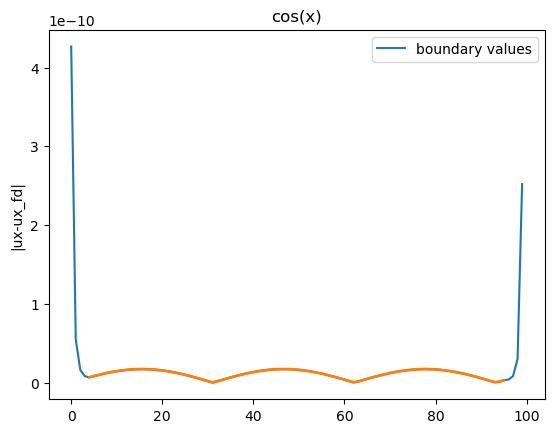

In [37]:
# Create a figure and axis
fig, ax = plt.subplots()
plt.title(function)
# Plotting the absolute differences
ax.plot(abs(ux - ux_fd), label='boundary values')
ax.plot(abs(ux - ux_fd_no_bound),linewidth=2.0)

# Adding labels and legend
ax.set_ylabel("|ux-ux_fd|")
ax.legend()

# Save the figure
plt.savefig(f'Images/absolute_differences_plot_{function}.png')

# Show the plot
plt.show()